In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Github_notebooks/Tests/multivariate-weather-data-clustering-main.zip

Archive:  /content/drive/MyDrive/Github_notebooks/Tests/multivariate-weather-data-clustering-main.zip
5b62d1afad6c4cc801357e9c47185da73a08f37e
   creating: multivariate-weather-data-clustering-main/
  inflating: multivariate-weather-data-clustering-main/.DS_Store  
  inflating: multivariate-weather-data-clustering-main/.gitignore  
   creating: multivariate-weather-data-clustering-main/Benchmark/
  inflating: multivariate-weather-data-clustering-main/Benchmark/.DS_Store  
   creating: multivariate-weather-data-clustering-main/Benchmark/Affinity_Propagation/
  inflating: multivariate-weather-data-clustering-main/Benchmark/Affinity_Propagation/Affinity_Propagation_PCA11_Norm.ipynb  
   creating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/
  inflating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/Git_testing_DBscan_SST_only.ipynb  
  inflating: multivariate-weather-data-clustering-main/Benchmark/Dbscan/Git_testing_DBscan_all_variables_.ipynb  
  inflating: mu

In [4]:
!mv multivariate-weather-data-clustering-main multivariateweatherdataclusteringmain

In [5]:
!pip install "dask[dataframe]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [25]:
path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily_smalldomain.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly.nc')
#path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
data = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
#data = xr.open_dataset(path2)# decode_times=False) #To view the date as integers of 0, 1, 2,....
#data5 = xr.open_dataset(path2) # To view time in datetime format
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [26]:
#!pip install "dask[dataframe]" #Needed for data transformation

import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

#from MWDC.preprocessing import datatransformation, datanormalization

from multivariateweatherdataclusteringmain.MWDC.preprocessing import *


def st_agglomerative(input, K, affinity, linkage):
  '''
  input parameters:

        input: 4-d spatio-temporal xarray

        k : interger, The number of our desired clusters

        proximity: function, The distance metric

        linkage: function, Linkage criteria

  Output:
         
        formed_clusters: 1-D array of cluster labels classifying each data point along the time dimension
                         to a cluster label

        A dataframe showing each cluster label and the correcponding cluster size.

        A dendrogram showing the steps in clustering
     
  '''


  #calling function that transforms our data
  trans_data = datatransformation(input)

  #Normalize data
  norm_data = datanormalization(trans_data)

  # calling the agglomerative algorithm and choosing n_clusters = 4 based on elbow value
  model = AgglomerativeClustering(K, affinity = 'euclidean', linkage = 'average')
  
  # training the model on transformed data
  y_model = model.fit(norm_data)
  labels = y_model.labels_

  df1 = pd.DataFrame(norm_data)
  df1['Cluster'] = labels
  df1['Cluster'].value_counts()

  #print("Estimated number of clusters: %d" % n_clusters_)
  print(df1['Cluster'].value_counts())

  # graph size
  plt.figure(1, figsize = (24 ,12))

  # creating the dendrogram
  dendrogram = sch.dendrogram(sch.linkage(norm_data, method  = "ward"))

  plt.axhline(y = 85, color='orange', linestyle ="--")

  # var = list(input.variables)
  var = list(input.variables)

  # ploting graphabs
  plt.title('Dendrogram')
  plt.xlabel(var)
  plt.ylabel('Euclidean distances')
  plt.show()
  
  return df1,labels

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


2    195
1    143
5     13
0      9
3      2
6      2
4      1
Name: Cluster, dtype: int64


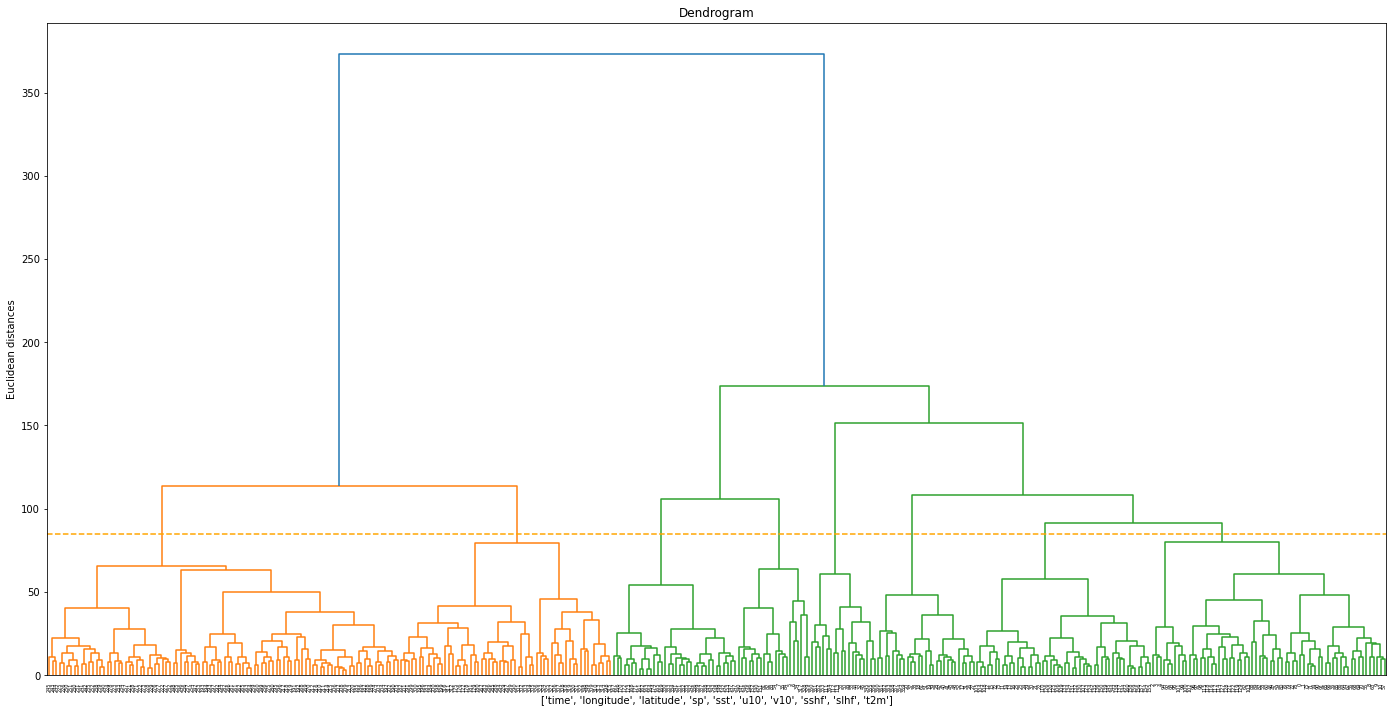

(       sp(43.0,-33.0)  sp(42.75,-33.0)  sp(42.5,-33.0)  sp(42.25,-33.0)  \
 0.0          0.769017         0.763551        0.758399         0.754214   
 1.0          0.550508         0.539280        0.528615         0.520168   
 2.0          0.406872         0.391876        0.377439         0.365852   
 3.0          0.305465         0.282306        0.260121         0.241803   
 4.0          0.421539         0.398652        0.376436         0.357109   
 ...               ...              ...             ...              ...   
 360.0        0.052561         0.047201        0.044078         0.046307   
 361.0        0.000000         0.000000        0.001187         0.007059   
 362.0        0.062689         0.061612        0.062288         0.067914   
 363.0        0.013697         0.005919        0.000000         0.000000   
 364.0        0.153705         0.148152        0.143691         0.143785   
 
        sp(42.0,-33.0)  sp(41.75,-33.0)  sp(41.5,-33.0)  sp(41.25,-33.0)  \
 0.0      

In [27]:
st_agglomerative(data, 7, affinity = 'euclidean', linkage = 'average')